In [3]:
from typing import Callable
from dataclasses import dataclass
from evaluation.eval_analysis import (
    find_shared_proofs,
    get_times_and_num_proofs,
    get_expansions_and_num_proofs,
    get_fine_grained_comparison_stats,
    get_shortest_failed_proof,
    get_combined_times_and_num_proofs,
    get_combined_expansions_and_num_proofs,
)
import matplotlib.pyplot as plt

In [4]:
EVAL_DIRS = [
    #("Depth First", "/home/ubuntu/coq-modeling/evals/eval/codellama-7b-basic-depth"),

    #("Breadth First", "/home/ubuntu/coq-modeling/evals/eval/codellama-7b-basic-breadth"),
    #("Depth First Sketchy", "/home/ubuntu/coq-modeling/evals/eval/codellama-7b-basic-depth-maybe-faulty"),
    #("Branch Normalized", "/home/ubuntu/coq-modeling/evals/eval/codellama-7b-basic-branch"),
    #("Greedy Last Tactic", "/home/ubuntu/coq-modeling/evals/eval/codellama-7b-basic-last-tac"),
    #("Token Normalized", "/home/ubuntu/coq-modeling/evals/eval/codellama-7b-basic-tok"),

    ("Single Tactic Dist", "/home/ubuntu/coq-modeling/evals/eval/codellama-7b-basic-dist"),
    ("Single Tactic Dist 2", "/home/ubuntu/coq-modeling/evals/eval/codellama-7b-basic-dist-2"),

    ("Single Tactic", "/home/ubuntu/coq-modeling/evals/eval/codellama-7b-basic-tok"),

    #("Single Tactic Reproduced", "/home/ubuntu/coq-modeling/evals/eval/codellama-7b-basic-tok-2"),
    #("Single Tactic Reproduced 2", "/home/ubuntu/coq-modeling/evals/eval/codellama-7b-basic-tok-3"),

    #("N Tactic Uniform", "/home/ubuntu/coq-modeling/evals/eval/codellama-7b-n-tac-unif"),
    #("N Tactic TPE 500", "/home/ubuntu/coq-modeling/evals/eval/codellama-7b-tpe-500"),
    #("N Tactic TPE 1k", "/home/ubuntu/coq-modeling/evals/eval/codellama-7b-tpe-1k"),

    #("Codellama base", "/home/ubuntu/coq-modeling/evals/eval_beam_ast_comp/codellama-7b-base"),
    #("Codellama finetuned", "/home/ubuntu/coq-modeling/evals/eval_beam_ast_comp/codellama-7b-basic"),

]

In [5]:
eval_dirs = [b for a, b in EVAL_DIRS]
shared_proof_names = find_shared_proofs(eval_dirs)

In [6]:

@dataclass
class PlotInfo: 
    xs: list[float]
    ys: list[int]
    name: str


def get_matching_x_axes(
    eval_dirs: list[tuple[str, str]],
    dir_to_metric_fn: Callable[[str, set[str]], tuple[list[float], list[int]]],
    dirs_to_metric_fn: Callable[[list[tuple[str, str]], set[str]], tuple[list[float], list[int]]],
) -> tuple[list[PlotInfo], PlotInfo]:
    eval_metrics: list[list[float]] = []
    eval_num_proofs: list[list[int]] = []
    eval_names: list[str] = []
    for eval_name, eval_path in eval_dirs:
        metric, num_proofs = dir_to_metric_fn(eval_path, shared_proof_names)
        eval_metrics.append(metric)
        eval_num_proofs.append(num_proofs)
        eval_names.append(eval_name)
    
    max_metric = max(map(lambda x: x[-1], eval_metrics))
    eval_plot_infos: list[PlotInfo] = []
    for name, metrics, num_proofs in zip(eval_names, eval_metrics, eval_num_proofs):
        if metrics[-1] == max_metric:
            eval_plot_infos.append(PlotInfo(metrics, num_proofs, name))
        else:
            eval_plot_infos.append(PlotInfo(metrics + [max_metric], num_proofs + [num_proofs[-1]], name))
    
    combined_metrics, combined_num_proofs = dirs_to_metric_fn(eval_dirs, shared_proof_names) 
    if combined_metrics[-1] == max_metric:
        combined_eval_plot = PlotInfo(combined_metrics, combined_num_proofs, "Combined")
    else:
        combined_eval_plot = PlotInfo(combined_metrics + [max_metric], combined_num_proofs + [combined_num_proofs[-1]], "Combined")
    return eval_plot_infos, combined_eval_plot 


  

Text(0.5, 1.0, '# Proofs found out of 581 Theorems.')

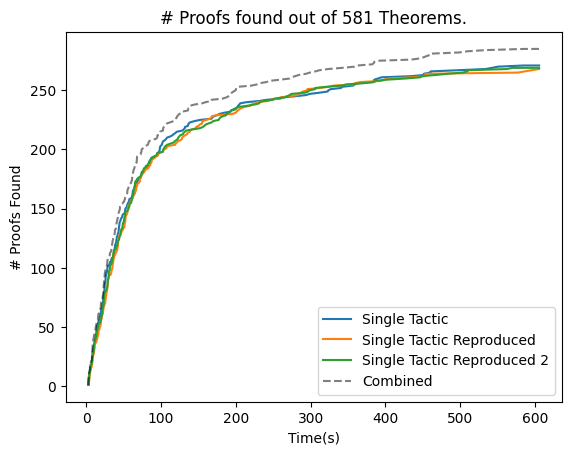

In [7]:
fig, ax = plt.subplots()
assert type(ax) == plt.Axes

plot_infos, combined_plot_info = get_matching_x_axes(
    EVAL_DIRS, get_times_and_num_proofs, get_combined_times_and_num_proofs 
)

for plot_info in plot_infos: 
    ax.plot(plot_info.xs, plot_info.ys, label=plot_info.name)

ax.plot(combined_plot_info.xs, combined_plot_info.ys, "--", label=combined_plot_info.name, color="black", alpha=0.5,)

ax.legend()
ax.set_xlabel("Time(s)")
ax.set_ylabel("# Proofs Found")
ax.set_title(f"# Proofs found out of {len(shared_proof_names)} Theorems.")


Text(0.5, 1.0, '# Proofs Found out of 581 Theorems.')

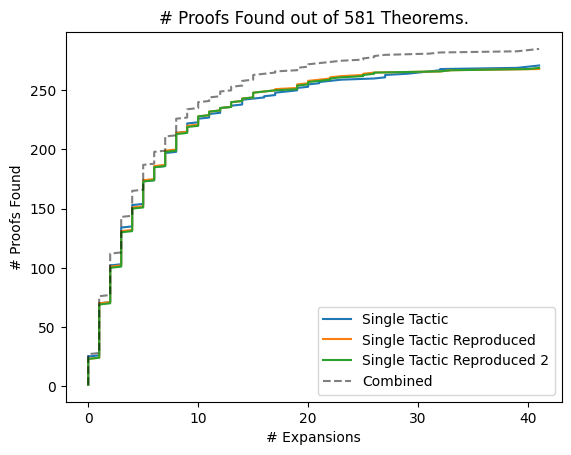

In [8]:
fig, ax = plt.subplots()
assert type(ax) == plt.Axes

plot_infos, combined_plot_info = get_matching_x_axes(
    EVAL_DIRS, get_expansions_and_num_proofs, get_combined_expansions_and_num_proofs 
)

for plot_info in plot_infos: 
    ax.plot(plot_info.xs, plot_info.ys, label=plot_info.name)

ax.plot(combined_plot_info.xs, combined_plot_info.ys, "--", label=combined_plot_info.name, color="black", alpha=0.5,)


ax.legend()
ax.set_xlabel("# Expansions")
ax.set_ylabel("# Proofs Found")
ax.set_title(f"# Proofs Found out of {len(shared_proof_names)} Theorems.")

In [9]:
get_fine_grained_comparison_stats(EVAL_DIRS, shared_proof_names)

Total Number of Theorems: 581.
Cardinality of union of all proofs found: 285
------------ Single Tactic -----------------
Number of proofs found: 271
Dominated by: []
Number of unique proofs found: 15

------------ Single Tactic Reproduced -----------------
Number of proofs found: 268
Dominated by: []
Number of unique proofs found: 1

------------ Single Tactic Reproduced 2 -----------------
Number of proofs found: 269
Dominated by: []
Number of unique proofs found: 1



In [10]:
get_shortest_failed_proof(EVAL_DIRS, "/home/ubuntu/coq-modeling/failed-examples")

/home/ubuntu/coq-modeling/failed-examples exists.
